## Введение в обработку изображений и свертки

In [1]:
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
IMAGE_PATH = "../images"

## PIL, numpy, простые операции

Для начала немного поиграем с представлениями изображений. Наиболее удобный способ читать картинки - через pillow

In [2]:
img = Image.open(f"{IMAGE_PATH}/kot_mjaukaet.jpg")

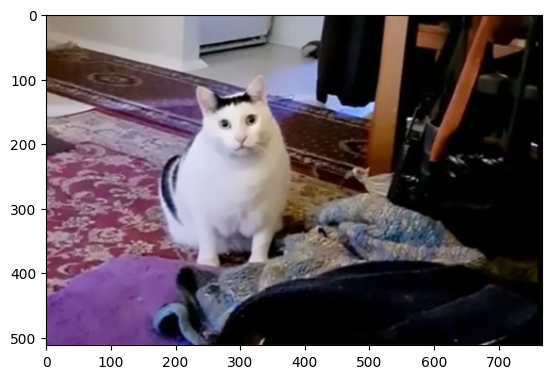

In [3]:
plt.imshow(img)

Вопрос: как вы думаете, что не так после преобразования изображения в np?

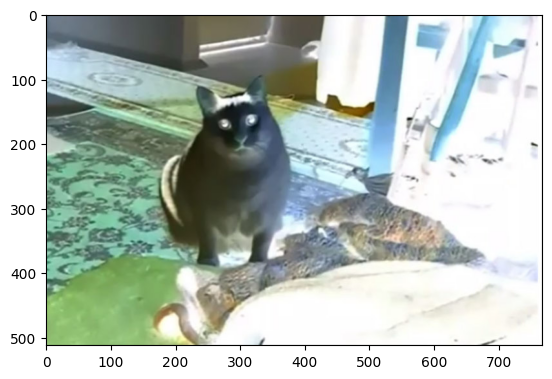

In [4]:
img_np = np.array(img)
plt.imshow(255 - img_np)
plt.show()

In [7]:
img_np.shape

(512, 768, 3)

Вопрос: Что получится после выполнения следующего кода?

In [ ]:
img_np = img_np[..., [2,1,0]]

(512, 768, 3)

Можно рассмотреть каждый канал отдельно

In [ ]:
from matplotlib import cm

# выведите три графика, на каждом только один канал. Чтобы задать схему, используйте colormaps:
# cmap=cm.Blues, etc

Можем кропнуть изображение

In [ ]:
plt.imshow(img.crop(box=(40, 40, 400, 450)))

**Задание**: кропните это изображение в numpy
**Дополнительное задание 1**: напишите функцию, которая будет принимать на вход numpy array с изображением и возвращать случайный кроп этого изображения заданного размера
Пример: random_crop(img_np, [30, 30]) -> img_np[0:30, 0:30]
**Дополнительное задание 2**: Напишите то же самое, но с PIL.Image


Конечно, можно и инвертировать изображение. Однако, многие продвинутые операции реализованы в модуле ImageChops

In [ ]:
from PIL import ImageChops
img = ImageChops.invert(img)
plt.imshow(img)

К тому же, изображение можно повернуть

In [ ]:
plt.imshow(img.rotate(45))

In [ ]:
cat2 = Image.open(f"{IMAGE_PATH}/kitten.jpg")
print(cat2.size)
plt.imshow(cat2)
cat2.mode

In [ ]:
cat2 = ImageChops.invert(cat2.resize((768//3, 512//3)))
plt.imshow(cat2)

Мы можем даже вставить одно изображение в другое. Обратите внимание, что вставка производится прямо в объект, так что нужно предварительн сделать копию, если хочется сохранить исходную картинку

In [ ]:
#cat2 = cat2.resize((768//3, 512//3))
new_img = img.copy()
new_img.paste(cat2.copy(), [450, 350])

In [ ]:
new_img

**Дополнительное задание**: напишите функцию, которая будет принимать на вход два изображения и добавлять в случайное место на первом второе

## CNN

В PyTorch свёрточный слой представлен в модуле torch.nn классом Conv2d (Conv1d) с параметрами:

- in_channels: количество входных каналов
- out_channels: количество выходных каналов
- kernel_size: размер ядра
- stride: значение в пикселях, на который будет сдвинуто ядро на каждом следующем шаге
- padding: значение в пикселях, ширина "рамки", которая будет добавлена вокруг изображения
- padding_mode: как будет заполняться паддинг ('zeros', 'reflect' и др.)
- dilation: шаг в пикселях, на который будет "разрежен" вход ядра

Что это значит?
Проще всего показать на [примерaх](https://github.com/vdumoulin/conv_arithmetic):
Пример простейшей свертки:
![alt text](..\images\Convolution_arithmetic_-_Padding_strides.gif "Stride=1, padding=0")

Если добавить паддинг, то можно, например, сохранить размер исходного изображения:
![alt text](..\images\same_padding_no_strides.gif "Stride=1, padding=1")




Мы будем пользоваться функцией pytorch для произведения свертки с заданным ядром (весами).

In [ ]:
from torch.nn.functional import conv2d

Рассмотрим несколько фильтров:

Фильтр улучшения четкости
[[ -1, -1, -1,],
[  -1, 9, -1],
[  -1, -1, -1]]

Фильтр Собеля - для выявления горизонтальных ребер
[[ -1, -1, -1,],
[  1, 1, 1],
[  -1, -1, -1]]
**Вопрос**: что нужно изменить для того, чтобы выявлять вертикальные ребра?

Функция ожидает на вход батчи, так что необходимо добавить новое измерение, чтобы получился виртуальный батч из 1 картинки. Кроме того, каналы должны оказаться в конце.

In [ ]:
img_tensor = torch.tensor(img_np, dtype=torch.float)
print(img_tensor.shape)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0)
img_tensor.size()

Потренируемся с фильтром Собеля. Нам нужно применить его ко всем каналам входного изображения, так что нужно его размножить.

In [ ]:
kernel = [[ -1, -1, -1,],
[  3, 3, 3],
[  -1, -1, -1]]
hor_filter = torch.tensor([[kernel, kernel, kernel]], dtype=torch.float)
hor_filter.size()

In [ ]:
hor_result = conv2d(img_tensor, hor_filter).squeeze()
plt.imshow(hor_result)

Задание: Создайте и примените вертикальный фильтр Собеля.

In [ ]:
# создайте ядро, размножьте и примените)

In [ ]:
# выведите изображение

**Задание.** Объединим результаты, получив представление всех ребер)
Например, это можно сделать, посчитав сумму квадратов результатов

In [ ]:
img_conv = # сумма квадратов результатов верт. и хор. фильтров
plt.imshow(img_conv)
plt.show()

Если мы попытаемя сделать также с фильтром усиления четкости, то получим одноканальное изображение. Это не очень хорошо. Мы хотим получить такую же картинку, как на входе, но четче. Простейший вариант - применить фильтр к каждому каналу отдельно. Попробуем сделать это.


In [ ]:
sharp_kernel = [[ -1, -1, -1,],
[  -1, 9, -1],
[  -1, -1, -1]]
weights = torch.tensor(sharp_kernel, dtype=torch.float).unsqueeze(0).unsqueeze(0)
res = torch.stack([conv2d(img_tensor[:, i,...], weights, padding=1) for i in range(3)], dim=1)

In [ ]:
plt.imshow(res.squeeze().permute(1,2,0).clip(0, 255).to(torch.int))

Однако, это не единственный способ. Можно воспользоваться depth-wise convolution. Обычная свертка делается сразу по всем каналам и мешает их как угодно. depth-wise convolution же, в свою очередь, делает следующие три шага:
- Разбивает фильтр и и вход на каналы
- Сворачивает дый канал отдельно соответствующим фильтром
- Конкатенирует результат

В torch.nn это уже реализовано в conv2d (Conv2d) с помощью параметра groups. На самом деле, эта возможность достаточно мощная. Она позволяет как уменьшить число параметров, сохраняя точность, так и применять группы сверток параллельно. Это очень полезно - чуть позже мы узнаем, какая модель, основанная на этой простой идее, когда-то порвала все лидерборды.

**Задание**: Примените ядро усиления четкости к трем каналам картинки с использованием параметра groups.

In [ ]:
sharp_kernel = # опишите ядро
weights = torch.tensor([sharp_kernel, sharp_kernel,sharp_kernel], dtype=torch.float)
weights = # добавьте новое измерение. Обратите внимание, что для depthwise-conv нужно формировать ядро так, чтобы батч был вторым

In [ ]:
sharp_result = conv2d(img_tensor, weights, padding=1, groups=3)
plt.imshow(sharp_result.squeeze().permute(1,2,0).clip(0, 255).to(torch.int))

**Задание**: Реализуйте и примените случайный фильтр
**Дополнительное задание**: Реализуйте и примените гауссовский фильтр. Этот фильтр дожен приводить к размытию входного изображения

Рассмотрим теперь слой nn.Conv2d. Синтаксис при его инстанциировании практически такой же, как у функции. Сверточный слой обучаемый, матрица весов инициализируется с помощью стратегии инициализации. Пользователю же необходимо задать входное и выходное число каналов и размер ядра.


In [ ]:
from torch import nn

conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)

In [ ]:
conv.weight.shape

Посмотрим на результат:

In [ ]:
sharp_result = conv(img_tensor)
plt.imshow(sharp_result.squeeze().permute(1,2,0).clip(0, 255).to(torch.int))

In [ ]:
from torch import nn

conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1, groups=3)
result = conv(img_tensor)
plt.imshow(result.squeeze().permute(1,2,0).clip(0, 255).to(torch.int))

 Вторая часть занятия пройдет в отдельном ноутбуке, simple_cnn_model